# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [6]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import time
%matplotlib inline

/tmp/ipykernel_9228/187924686.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
/tmp/ipykernel_9228/187924686.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map_img = imageio.imread('./map/vivocity_freespace.png')


Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


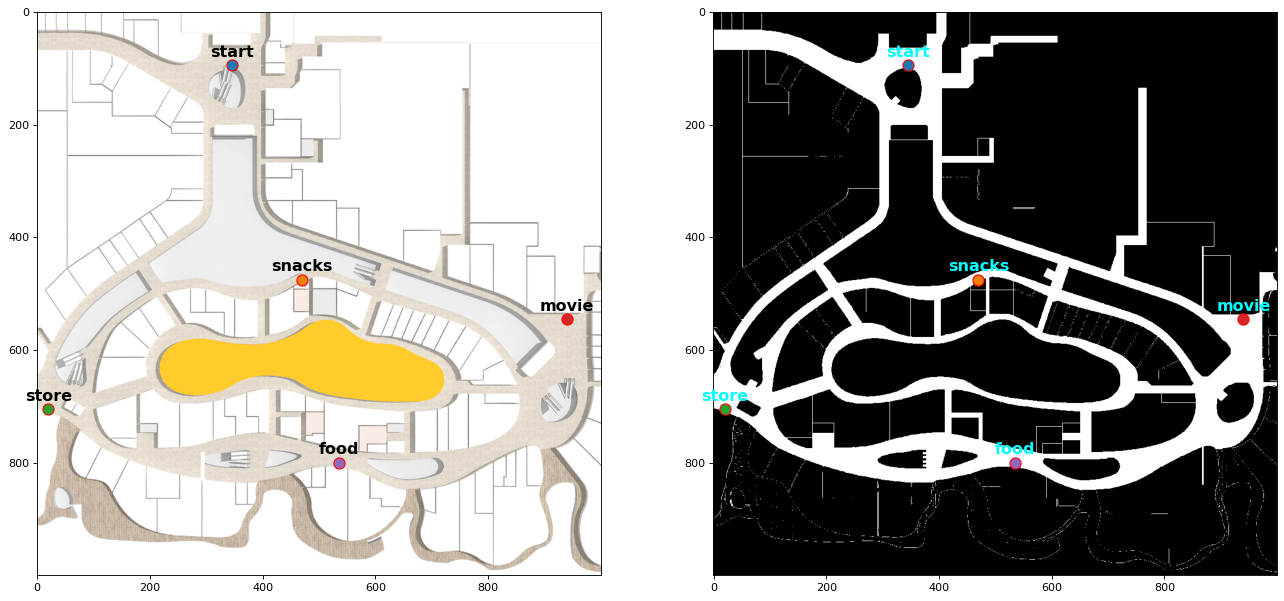

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [7]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

Implement A*

Total Travelled Distance: 142.43 m
Total Run Time: 1.4300227165222168 seconds
Number of cells visited by A* algorithm: 149554


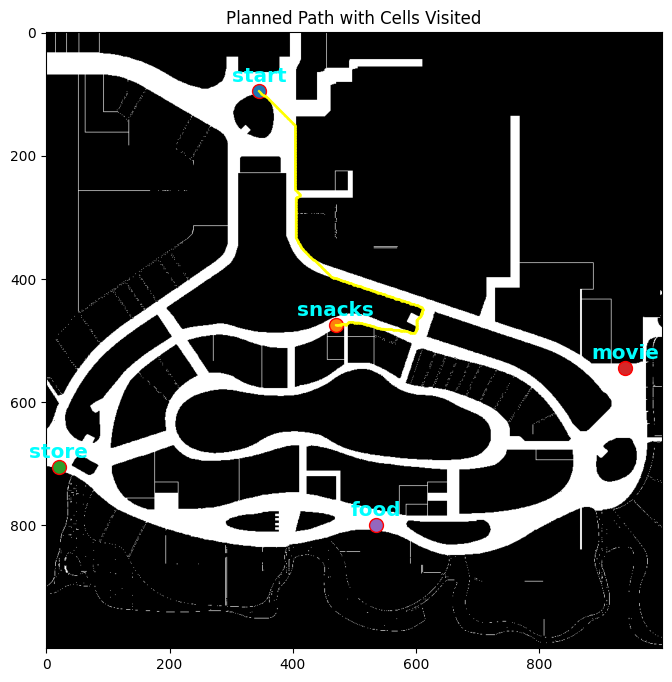

In [16]:
# Implementing A* algorithm
def heuristic_cost_estimate(start, goal):
    return np.sqrt((start[0] - goal[0]) ** 2 + (start[1] - goal[1]) ** 2)

def reconstruct_path(came_from, current):
    total_path = [current]
    while current in came_from:
        current = came_from[current]
        total_path.append(current)
    return total_path

def a_star(start, goal, grid_map):
    open_set = {start}
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic_cost_estimate(start, goal)}
    
    visited_cells = 0  # 初始化访问的单元格数量

    while open_set:
        current = min(open_set, key=lambda x: f_score[x])
        if current == goal:
            return reconstruct_path(came_from, goal), g_score[goal], visited_cells

        open_set.remove(current)
        
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                
                neighbor = (current[0] + dx, current[1] + dy)
                if not (0 <= neighbor[0] < grid_map.shape[0] and 0 <= neighbor[1] < grid_map.shape[1]):
                    continue
                
                if grid_map[neighbor[0], neighbor[1]] != 255:
                    continue
                
                visited_cells += 1  # 更新访问的单元格数量

                cost = 0.2 if dx == 0 or dy == 0 else 0.282
                
                wall_neighbor = (current[0] + dx * 2, current[1] + dy * 2)
                if wall_neighbor[0] >= 0 and wall_neighbor[0] < grid_map.shape[0] and wall_neighbor[1] >= 0 and wall_neighbor[1] < grid_map.shape[1]:
                    if grid_map[wall_neighbor[0], wall_neighbor[1]] != 255:
                        continue

                tentative_g_score = g_score[current] + cost
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic_cost_estimate(neighbor, goal)
                    if neighbor not in open_set:
                        open_set.add(neighbor)

    return None, float('inf'), visited_cells

# 修改后的部分
# Finding path from start to store
start_time = time.time()
path, total_distance, visited_cells = a_star(tuple(locations['start']), tuple(locations['snacks']), grid_map)
end_time = time.time()
#print("Planned Path:", path)
print("Total Travelled Distance:", round(total_distance, 3), "m")
print("Total Run Time:", end_time - start_time, "seconds")
print("Number of cells visited by A* algorithm:", visited_cells)
#print("Number of nodes in the planned path:", len(path))

# Visualize the planned path and cells visited
plt.figure(figsize=(8, 8))
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
if path:
    path_x, path_y = zip(*path)
    plt.plot(path_x, path_y, marker='o', color='yellow', markersize=0.5, linestyle='-')
plt.title('Planned Path with Cells Visited')
plt.show()


Adjacency matrix output

In [15]:
# 创建一个邻接矩阵来存储每对点之间的距离
matrix = np.zeros((len(locations), len(locations)))

# 使用两个嵌套循环来计算每对点之间的距离
for i, (name1, point1) in enumerate(locations.items()):
    for j, (name2, point2) in enumerate(locations.items()):
        if i == j:
            continue
        _, distance, _ = a_star(tuple(point1), tuple(point2), grid_map)
        matrix[i, j] = distance

print(matrix)

[[  0.    142.43  161.668 180.524 229.924]
 [152.752   0.    121.574 129.752 136.446]
 [165.282 116.492   0.    252.724 114.286]
 [182.656 108.352 236.762   0.    198.432]
 [233.408 130.354 119.862 117.574   0.   ]]


 Implement Dijkstra

Total Travelled Distance: 140.882 m
Total Run Time: 2.1307804584503174 seconds
Number of cells visited by Dijkstra algorithm: 679214


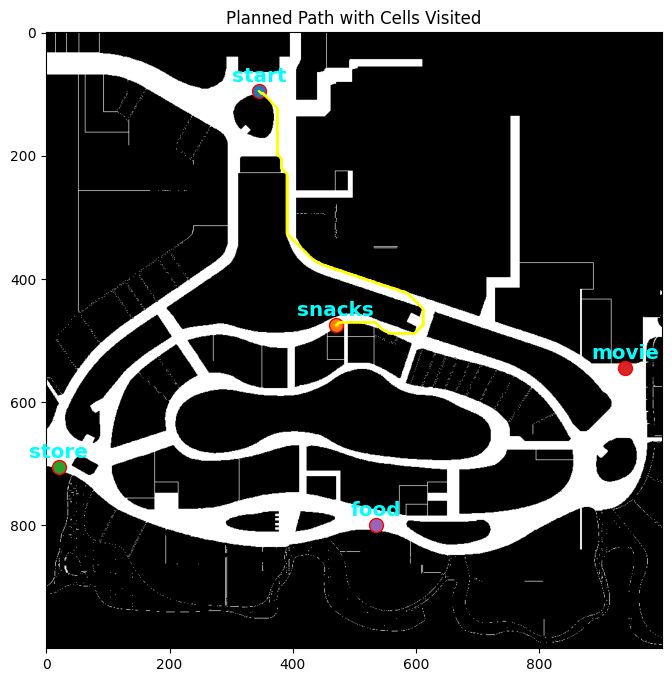

In [17]:
import heapq

def dijkstra(start, goal, grid_map):
    open_set = [(0, start)]
    came_from = {}
    g_score = {start: 0}
    
    visited_cells = 0  # 初始化访问的单元格数量

    while open_set:
        current_g_score, current = heapq.heappop(open_set)
        if current == goal:
            return reconstruct_path(came_from, goal), current_g_score, visited_cells

        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                
                neighbor = (current[0] + dx, current[1] + dy)
                if not (0 <= neighbor[0] < grid_map.shape[0] and 0 <= neighbor[1] < grid_map.shape[1]):
                    continue
                
                if grid_map[neighbor[0], neighbor[1]] != 255:
                    continue
                
                visited_cells += 1  # 更新访问的单元格数量

                cost = 0.2 if dx == 0 or dy == 0 else 0.282
                
                wall_neighbor = (current[0] + dx * 2, current[1] + dy * 2)
                if wall_neighbor[0] >= 0 and wall_neighbor[0] < grid_map.shape[0] and wall_neighbor[1] >= 0 and wall_neighbor[1] < grid_map.shape[1]:
                    if grid_map[wall_neighbor[0], wall_neighbor[1]] != 255:
                        continue

                tentative_g_score = g_score[current] + cost
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    heapq.heappush(open_set, (tentative_g_score, neighbor))

    return None, float('inf'), visited_cells

# 修改后的部分
# Finding path from start to store
start_time = time.time()
path, total_distance, visited_cells = dijkstra(tuple(locations['start']), tuple(locations['snacks']), grid_map)
end_time = time.time()
#print("Planned Path:", path)
print("Total Travelled Distance:", round(total_distance, 3), "m")
print("Total Run Time:", end_time - start_time, "seconds")
print("Number of cells visited by Dijkstra algorithm:", visited_cells)
#print("Number of nodes in the planned path:", len(path))

# Visualize the planned path and cells visited
plt.figure(figsize=(8, 8))
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
if path:
    path_x, path_y = zip(*path)
    plt.plot(path_x, path_y, marker='o', color='yellow', markersize=0.5, linestyle='-')
plt.title('Planned Path with Cells Visited')
plt.show()

## Task 2

In [11]:
# 创建一个完全图
graph = nx.complete_graph(locations.keys())

test_count = 0
# 初始化所有边的权重为0
for u, v in graph.edges():
    test_count += 1
    graph[u][v]['weight'] = test_count

# 输出图的基本信息来确认
print("Nodes in the graph:", graph.nodes())
# 打印邻接矩阵
print("Adjacency Matrix:")
print(nx.to_numpy_array(graph, weight='weight'))

Nodes in the graph: ['start', 'snacks', 'store', 'movie', 'food']
Adjacency Matrix:
[[ 0.  1.  2.  3.  4.]
 [ 1.  0.  5.  6.  7.]
 [ 2.  5.  0.  8.  9.]
 [ 3.  6.  8.  0. 10.]
 [ 4.  7.  9. 10.  0.]]


In [14]:
# 开始计时
start_time = time.time()

# 假设 graph 是你的图对象
# 确保 nodes 是图中节点的列表，node_index 是节点到索引的映射
nodes = list(graph.nodes())
n = len(nodes)
node_index = {node: i for i, node in enumerate(nodes)}

# 初始化 dp 和 parent 数组
dp = np.full((1 << n, n), np.inf)
parent = np.full((1 << n, n), -1)
dp[1][0] = 0  # 假设从节点 0 开始

# 动态规划计算
for mask in range(1, 1 << n):
    for u in range(n):
        if not (mask & (1 << u)):
            continue
        for v in range(n):
            if mask & (1 << v) and v != u:
                prev_mask = mask ^ (1 << u)
                if dp[prev_mask][v] + graph[nodes[v]][nodes[u]]['weight'] < dp[mask][u]:
                    dp[mask][u] = dp[prev_mask][v] + graph[nodes[v]][nodes[u]]['weight']
                    parent[mask][u] = v

# 重建路径
mask = (1 << n) - 1
u = np.argmin(dp[-1])
sequence = [u]

while u != -1:
    v = parent[mask][u]
    if v != -1:
        sequence.append(v)
    mask = mask ^ (1 << u)
    u = v

sequence = sequence[::-1]  # 反转序列以得到正确的顺序
path = [nodes[i] for i in sequence]  # 将索引转换回节点名称

# 计算总旅行距离
total_distance = sum(graph[path[i]][path[i+1]]['weight'] for i in range(n-1)) + graph[path[-1]][path[0]]['weight']

# 结束计时
end_time = time.time()

# 输出结果
print("Visit order:", path)
print("Total Travelled Distance:", round(total_distance, 3), "m")
print("Total Run Time:", round(end_time - start_time, 3), "seconds")


Visit order: ['start', 'movie', 'store', 'snacks', 'food']
Total Travelled Distance: 27 m
Total Run Time: 0.005 seconds
